Welcome to Argoverse! We'll show some quick ways to get started with the Argoverse maps:

Note that to run this tutorial, you'll need to install the `mayavi` python package. See the instruction on how to install it [here](https://docs.enthought.com/mayavi/mayavi/installation.html)

# Map API

To access our map API, simply create an `ArgoverseMap`

In [2]:

tracking_dataset_dir = '/media/bartosz/hdd1TB/workspace_hdd/datasets/argodataset/argoverse-tracking/sample/'


In [3]:
from argoverse.map_representation.map_api import ArgoverseMap
import numpy as np
am = ArgoverseMap()

## Lane Polygon

`ArgoverseMap.find_local_lane_polygons` can be used to retrieve polygon of lanes in the specified area. 

As an example, we will get a city coordinate of the car from log 0, frame 10, and show the first 5 lane polygons within 60 meters around the cars.

In [4]:
from argoverse.data_loading.argoverse_tracking_loader import ArgoverseTrackingLoader

log_index = 0
frame_index = 100
idx = 100
argoverse_loader = ArgoverseTrackingLoader(tracking_dataset_dir)
log_id = argoverse_loader.log_list[log_index]
argoverse_data = argoverse_loader[log_index]
city_name = argoverse_data.city_name

lidar_pts = argoverse_data.get_lidar(idx)

In [5]:
"""
The coordinate used in `ArgoverseMap` is a city coordinate, while the 
annotation in `Argoverse-Tracking` dataset is in egovehicle coordinate. 

These `egovehicle` can be converted to city coodinate using pose information 
available in the dataset. 
"""
x,y,_ = argoverse_data.get_pose(frame_index).translation

---------------------------------------------
------Example of getting lane polygon--------
---------------------------------------------


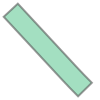

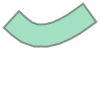

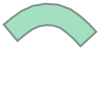

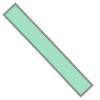

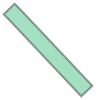

In [6]:
from shapely.geometry.polygon import Polygon
print('---------------------------------------------')
print('------Example of getting lane polygon--------')
print('---------------------------------------------')
for i in range(5):
    #Use the corresponding city name with log id
    display(Polygon(am.find_local_lane_polygons([x-30, x+30, y-30, y+30], 'PIT')[i])) 

## Driveable Area

Driveable area can also be queried in the same way,

--------------------------------------------------------
------Example of getting region of driveable area--------
--------------------------------------------------------


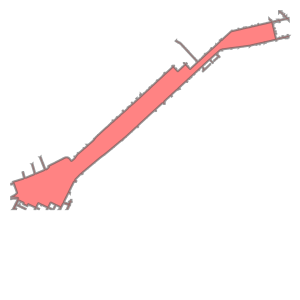

In [7]:
print('--------------------------------------------------------')
print('------Example of getting region of driveable area--------')
print('--------------------------------------------------------')
# display(Polygon(am.find_local_driveable_areas([x-30, x+30, y-30, y+30], 'PIT')[0]))
display(Polygon(am.find_local_driveable_areas([x-30, x+30, y-30, y+30], 'PIT')[0]))
# local_driveable_areas = am.find_local_driveable_areas([x, x, y, y],'PIT')
# for i in range(local_driveable_areas.shape[0]):
#     print(i)
#     display(Polygon(local_driveable_areas[i]))

# Visualize map on the data

Here we will visualize map infromation on top of our data from `Argoverse-Tracking` dataset. 

In [8]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
from visualize_30hz_benchmark_data_on_map import DatasetOnMapVisualizer

# Map from a bird's-eye-view (BEV)
dataset_dir = tracking_dataset_dir
experiment_prefix = 'visualization_demo'

#if you are running for the first time, or using a new set of logs, this will need to be set False to accumelate the labels again
use_existing_files = True

city_to_egovehicle_se3 = argoverse_data.get_pose(idx)

import logging
logger = logging.getLogger()
logger.setLevel(logging.CRITICAL)

domv = DatasetOnMapVisualizer(dataset_dir, experiment_prefix, use_existing_files=use_existing_files, log_id=argoverse_data.current_log)


One example is to overlay our label annotations on top of our map information. Here the pink area denotes the `driveable area`

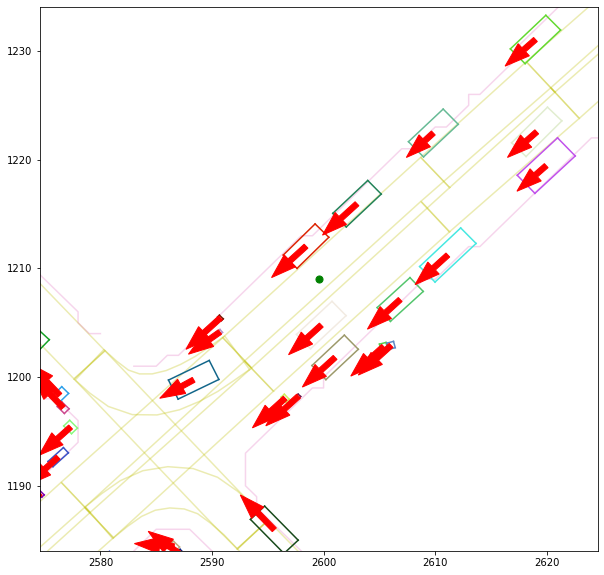

In [29]:
import copy

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
xcenter,ycenter,_ = argoverse_data.get_pose(idx).translation

r = 25
xmin = xcenter - r  # 150
xmax = xcenter + r  # 150
ymin = ycenter - r  # 150
ymax = ycenter + r  # 150
ax.scatter(xcenter, ycenter, 200, color="g", marker=".", zorder=2)
ax.set_xlim([xmin, xmax])
ax.set_ylim([ymin, ymax])
local_lane_polygons = am.find_local_lane_polygons([xmin, xmax, ymin, ymax], city_name)
local_das = am.find_local_driveable_areas([xmin, xmax, ymin, ymax], city_name)



domv.render_bev_labels_mpl(
    city_name,
    ax,
    "city_axis",
    None,
    copy.deepcopy(local_lane_polygons),
    copy.deepcopy(local_das),
    log_id,
    argoverse_data.lidar_timestamp_list[idx],
    city_to_egovehicle_se3,
    am,
    vis_other_objects = True
)


In [10]:
objects = domv.log_timestamp_dict[log_id][argoverse_data.lidar_timestamp_list[idx]]
len(objects)
for i, obj in enumerate(objects):
    print(np.linalg.norm(argoverse_data.get_pose(idx).translation - np.mean(obj.bbox_city_fr, axis=0)))

7.636658958481904
11.381812834880238
3.424549938824744
7.8139961434047995
25.834741263089757
14.618009075329153
98.8140018709125
8.645526713054892
26.131135284208213
127.25779654845682
71.05488583941369
16.954120030078503
63.910928458338496
9.508140618300633
35.977718757821
192.12621757875536
4.482684022676255
63.55148682305231
60.29326182922166
54.832018905038375
115.37416966257712
11.86708274228457
27.858708261778816
23.444612074068186
31.51360143637011
28.58155358445839
49.971287712635124
69.473585600269
118.47118742224205
28.249044708747466
32.52966827992627
96.43537482691096
56.77539893131291
152.67491566939148
118.73563631611377
38.78169135798344
23.80077199933953
49.95680229750054
29.39787159513077
87.0777498447656
56.66043470528513
49.61992271641439
25.561615455413914
96.61887048861642
137.10599056009994
9.042627671236817
87.3357020135713
26.671093664306404
22.943688439086408
37.55121948932364
10.93718225078956
47.66313353331036
7.527889426048833
10.117581211086234
132.11526740

Similarly, we can also plot map info on top of lidar point clouds.

## Removing points

In many cases, we are only intersted in points that belong to the objects of interest (e.g. cars on the road).

We can filter out any points that lie outside of the driveable area, by simply using `ArgoverseMap.remove_non_driveable_area_points`

Additionally, we can remove points that belong to the ground surface by using `Argoverse.remove_ground_surface`.

This leaves us with points that belong to objects inside the driveable area, which are shown as colored points.

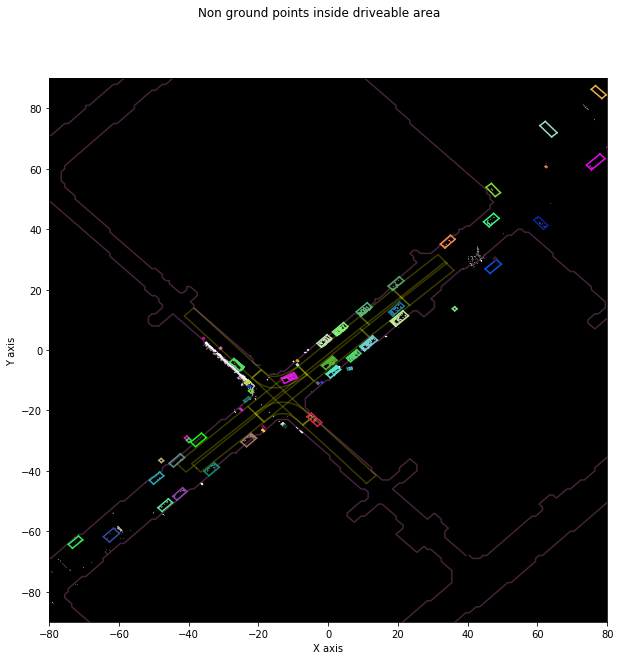

In [11]:
fig = plt.figure(figsize=(10,10))
fig.suptitle('Non ground points inside driveable area')
ax = fig.add_subplot(111)

driveable_area_pts = copy.deepcopy(lidar_pts)
driveable_area_pts = city_to_egovehicle_se3.transform_point_cloud(
    driveable_area_pts
)  # put into city coords
driveable_area_pts = am.remove_non_driveable_area_points(driveable_area_pts, city_name)
driveable_area_pts = am.remove_ground_surface(driveable_area_pts, city_name)
driveable_area_pts = city_to_egovehicle_se3.inverse_transform_point_cloud(
    driveable_area_pts
)

domv.render_bev_labels_mpl(
    city_name,
    ax,
    "ego_axis",
    driveable_area_pts,
    copy.deepcopy(local_lane_polygons),
    copy.deepcopy(local_das),
    log_id,
    argoverse_data.lidar_timestamp_list[idx],
    city_to_egovehicle_se3,
    am,
)

We can also overlay them on images from our camera sensors.

In [12]:
import argoverse.visualization.visualization_utils as viz_util
from argoverse.utils.frustum_clipping import generate_frustum_planes
from PIL import Image 
from cuboids_to_bboxes import plot_lane_centerlines_in_img
camera = 'ring_front_center'

In [13]:
img = argoverse_data.get_image_sync(idx,camera = camera)
objects = argoverse_data.get_label_object(idx)
calib = argoverse_data.get_calibration(camera)

lidar_pts = argoverse_data.get_lidar(idx)
calib = argoverse_data.get_calibration(camera=camera)
planes = generate_frustum_planes(calib.camera_config.intrinsic.copy(), camera)

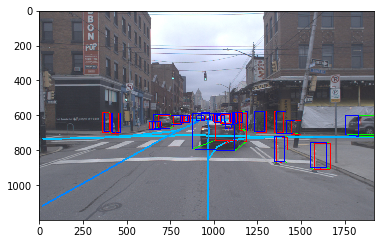

In [14]:
img_wlane = plot_lane_centerlines_in_img(lidar_pts, city_to_egovehicle_se3, img, city_name, am, calib.camera_config, planes)
#display(Image.fromarray(img_wlane))
img_vis = viz_util.show_image_with_boxes(img,objects,calib)
# display(Image.fromarray(img_vis))
# plt.imshow(img_vis)

plt.imshow(img_vis)

(1200, 1920, 3)

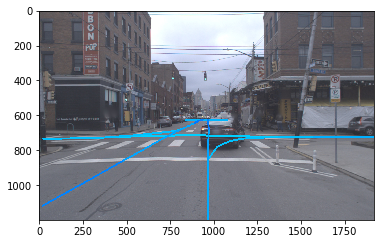

In [15]:
img = argoverse_data.get_image_sync(idx,camera = camera, load=True)
# plt.imshow(img)
# img_vis = viz_util.show_image_with_boxes(img,objects,calib)
plt.imshow(img_wlane)
img.shape

In [20]:

objects_domv = domv.log_timestamp_dict[log_id][argoverse_data.lidar_timestamp_list[idx]]
objects_data = argoverse_data.get_label_object(idx)

# for i, obj in (enumerate(objects_domv)):
#     print(np.linalg.norm(argoverse_data.get_pose(idx).translation - np.mean(obj.bbox_city_fr, axis=0)))

# print ("--")
# objects = argoverse_data.get_label_object(idx)
# for i, obj in (enumerate(objects)):
#     print(np.linalg.norm(argoverse_data.get_pose(idx).translation - np.mean(obj.as_2d_bbox(), axis=0)))
               
#     img_vis = viz_util.show_image_with_boxes(img,[obj],calib)
#     plt.imshow(img_vis)
#     plt.show)
# objects = domv.log_timestamp_dict[log_id][argoverse_data.lidar_timestamp_list[idx]]

# img_vis = viz_util.show_image_with_boxes(img,[objects[0]],calib)
# plt.imshow(img_vis)

# len(objects), objects[0].as_2d_bbox()
# objects_domv[0].bbox_city_fr, 
print(objects_domv[0].bbox_ego_frame, np.mean(objects_domv[0].bbox_ego_frame, axis=0), objects_data[0].translation)

for i, obj in enumerate(objects_data):
    print(obj.translation)

[[-2.07546187  7.24130415  1.10657278]
 [-2.06318287  5.50134748  1.10654801]
 [-6.10536152  7.21286487  1.10657807]
 [-6.09308253  5.4729082   1.1065533 ]] [-4.0842722   6.35710617  1.10656304] [2.70613345 3.29079863 0.58175133]
[2.70613345 3.29079863 0.58175133]
[-98.60301191   6.29104092   0.50924588]
[-106.35797558    5.76352874    0.57142954]
[-63.54022787   0.14344501   0.26257857]
[-118.69039189   -2.8334499     0.71043788]
[ 23.6727799  -27.0906394   -0.02815523]
[ 1.32072155e+02 -3.23588657e+00  6.53076429e-02]
[96.40058774 -2.38610917  0.16191067]
[-23.53706222   3.32674647   0.40517164]
[-55.70397637  10.24689252   0.27578597]
[-192.01260083    6.36140099    1.05246483]
[28.27704424 -3.77056258  0.76456173]
[-7.33713423e+01  1.04430408e+01  7.29846900e-02]
[24.30099706 -7.86249989  0.27840729]
[14.52493347 -0.76873312  0.63824223]
[-70.72026633  -6.80920414   0.11204892]
[-22.05126927   6.18759117   0.45158017]
[87.2786253   2.88817197  0.37097519]
[24.86127697 -6.8091614   